# Imports, read log and metrics

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from sklearn.metrics import jaccard_score
import cv2
import math
# import fastwer
# import pytesseract
# %matplotlib widget

def read_train_log (log_file):
    """ 
    Reads log file, with KAIR structure (https://github.com/cszn/KAIR), and retrieves training/validation information.

    Args:
    - log_file (str): path to the log file containing the training information.

    Returns:
    - train_info (dict): dictionary with 'epochs' 'lr', 'iters' and 'loss' training information as arrays.
    - train_info (dict): dictionary with 'epochs' 'iters', 'avgloss' and 'avgPSNR' validation information as arrays.
    """

    # Initialize lists for train
    epoch_list = []
    lr_list = []
    iter_list = []
    loss_list = []

    # Initialize lists for val
    val_epoch_list = []
    val_iter_list = []
    val_avgloss_list = []
    val_avgPSNR_list = []
    val_avgSSIM_list = []
    val_avgJaccard_list = []

    # Read log file
    with open(log_file, 'r') as file:
        for line in file:

            # Training log line:
            # Filter log for train info ('Average' is included in test information)
            if '<epoch:' in line and not( 'Average' in line):
                epoch = int(line.split('<')[1].split('epoch:')[1].split(',')[0].strip())
                pre_iter = line.split('<')[1].split('iter:')[1].split(', lr')[0].strip()
                
                if ',' in pre_iter:
                    iter = 1000*int(pre_iter.split(',')[0]) + int(pre_iter.split(',')[1])
                else:
                    iter = int(pre_iter)
                lr = float(line.split('<')[1].split('lr:')[1].split('>')[0].strip())
                loss = float(line.split('G_loss:')[1])
                epoch_list.append(epoch)
                lr_list.append(lr)
                iter_list.append(iter)
                loss_list.append(loss)

            # Validation log line:
            # Filter log for train info ('Average' is included in test information)
            if ('<epoch:' in line) and ('Average' in line):
                epoch = int(line.split('<')[1].split('epoch:')[1].split(',')[0].strip())
                pre_iter = line.split('<')[1].split('iter:')[1].split(', Average PSNR')[0].strip()
                
                if ',' in pre_iter:
                    iter = 1000*int(pre_iter.split(',')[0]) + int(pre_iter.split(',')[1])
                else:
                    iter = int(pre_iter)

                if 'PSNR' in line:
                    avgPSNR = float(line.split('<')[1].split('Average PSNR :')[1].split('dB')[0].strip())
                    val_avgPSNR_list.append(avgPSNR)
                if 'SSIM' in line:
                    avgSSIM = float(line.split('Average SSIM :')[1].split(',')[0].strip())
                    val_avgSSIM_list.append(avgSSIM)
                if 'edgeJaccard' in line:
                    avgJaccard = float(line.split('Average edgeJaccard :')[1].split(',')[0].strip())
                    val_avgJaccard_list.append(avgJaccard)
                avgloss = float(line.split('loss :')[1])

                val_epoch_list.append(epoch)
                val_iter_list.append(iter)
                val_avgloss_list.append(avgloss)
                
    # Lists to array
    epoch_array = np.array(epoch_list)
    lr_array = np.array(lr_list)
    iter_array = np.array(iter_list)
    loss_array = np.array(loss_list)

    val_epoch_array = np.array(val_epoch_list)
    val_iter_array = np.array(val_iter_list)
    val_avgloss_array = np.array(val_avgloss_list)
    val_avgPSNR_array = np.array(val_avgPSNR_list)
    val_avgSSIM_array = np.array(val_avgSSIM_list)
    val_avgJaccard_array = np.array(val_avgJaccard_list)

    train_info = {'epochs': epoch_array, 'lr': lr_array, 'iters':iter_array, 'loss':loss_array}
    val_info = {'epochs': val_epoch_array, 'iters':val_iter_array, 
                'loss':val_avgloss_array, 'PSNR':val_avgPSNR_array,
                'SSIM': val_avgSSIM_array, 'edgeJaccard':val_avgJaccard_array}

    return train_info, val_info

def filter_impulses(array):
    filtered_array = array.copy()
    for i in range(len(array)-2):
        if (array[i+1]<array[i]) and (array[i+1]<array[i+2]):
            filtered_array[i+1] = array[i] 
    return filtered_array

In [2]:
def process_logfile(logfile):
    train_info, val_info = read_train_log (logfile)

    psnr_val = val_info['PSNR']
    val_epochs = np.arange(len(train_info['loss'])//len(psnr_val),len(train_info['loss'])+1,len(train_info['loss'])//len(psnr_val))

    metrics = [metric for metric in ['PSNR','SSIM','edgeJaccard'] if (len(val_info[metric])!=0)]

    _, ax = plt.subplots(nrows=1, ncols= 1+len(metrics), figsize=(15, 5))
    ax[0].set_title('Aprendizaje')
    ax[0].plot(train_info['loss'], 'b', label='train loss')
    ax[0].plot(val_epochs, val_info['loss'],'r', label='val loss')
    ax[0].axhline(y=np.min(train_info['loss']), color='orange', linestyle='-')
    ax[0].grid()
    ax[0].legend()

    for idx, metric in enumerate(metrics):
        ax[1+idx].set_title(metric)
        ax[1+idx].plot(val_epochs,val_info[metric],'r')
        ax[1+idx].grid()

    plt.tight_layout()

    plt.show()

In [3]:
"""  
##############################
            METRICS
##############################
"""

# --------------------------------------------
# Edge Jaccard
# --------------------------------------------

def calculate_edge_jaccard(img1, img2):

    # Empyrical edges thresholds
    thr1, thr2 = 230, 400

    # Canny filtering
    img1_canny = (cv2.Canny(img1,thr1,thr2,apertureSize = 3) > 0)*1
    img2_canny = (cv2.Canny(img2,thr1,thr2,apertureSize = 3) > 0)*1

    # Jaccard index
    edge_jaccard= jaccard_score(img1_canny.ravel(),img2_canny.ravel())

    return edge_jaccard


# --------------------------------------------
# PSNR
# --------------------------------------------
def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    #img1 = img1.squeeze()
    #img2 = img2.squeeze()
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


# --------------------------------------------
# SSIM
# --------------------------------------------

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2, border=0):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    #img1 = img1.squeeze()
    #img2 = img2.squeeze()
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1[:,:,i], img2[:,:,i]))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

# --------------------------------------------
# CER & WER w/ Tesseract OCR
# --------------------------------------------

# def calculate_cer_wer(img_E, img_H):
#     # Transcribe ground-truth image to text
#     text_H = pytesseract.image_to_string(img_H).strip().replace('\n',' ')

#     # Transcribe estimated image to text
#     text_E = pytesseract.image_to_string(img_E).strip().replace('\n',' ')

#     cer = fastwer.score_sent(text_E, text_H, char_level=True)
#     wer = fastwer.score_sent(text_E, text_H)

#     return cer, wer


def compare_with_gt(H_path, L_path, E_path):
    # GT as mean of RGB channels
    img_H = np.mean(imread(H_path),axis=2)
    # Observed image
    img_L = imread(L_path)
    img_L_real, img_L_imag = img_L[:,:,0], img_L[:,:,1]
    img_L_suma = img_L_real + img_L_imag
    img_L_abs = np.abs(img_L_real + 1j*img_L_imag)
    # Inference image
    img_E = imread(E_path)

    metrics = ["CER", "WER", "edgeJaccard","PSNR", "SSIM"]

    # cer_L_real, wer_L_real = calculate_cer_wer(img_L_real.astype("uint8"), img_H)
    # cer_L_imag, wer_L_imag = calculate_cer_wer(img_L_imag.astype("uint8"), img_H)
    # cer_L_abs, wer_L_abs = calculate_cer_wer(img_L_abs.astype("uint8"), img_H)
    # cer_E, wer_E = calculate_cer_wer(E_path, img_H)

    psnr_L_real = calculate_psnr(img_L_real, img_H)
    psnr_L_imag = calculate_psnr(img_L_imag, img_H)
    psnr_L_abs = calculate_psnr(img_L_abs, img_H)
    psnr_E = calculate_psnr(img_E, img_H)

    ssim_L_real = calculate_ssim(img_L_real, img_H)
    ssim_L_imag = calculate_ssim(img_L_imag, img_H)
    ssim_L_abs = calculate_ssim(img_L_abs, img_H)
    ssim_E = calculate_ssim(img_E, img_H)

    edgeJaccard_L_real = calculate_edge_jaccard(img_L_real, img_H.astype("uint8"))
    edgeJaccard_L_imag = calculate_edge_jaccard(img_L_imag, img_H.astype("uint8"))
    edgeJaccard_L_abs = calculate_edge_jaccard(img_L_abs.astype("uint8"), img_H.astype("uint8"))
    edgeJaccard_E = calculate_edge_jaccard(img_E, img_H.astype("uint8"))

    _, ax = plt.subplots(3,2, figsize=(15,10),sharex=True, sharey=True)

    ax[0,0].imshow(img_H, cmap="gray", ), ax[0,0].axis("off"), ax[0,0].set_title("Ground-Truth")

    titulo_end2end = f'''End2End 
    Jaccard = {edgeJaccard_E},
    PSNR = {psnr_E}, SSIM = {ssim_E}'''
    ax[0,1].imshow(img_E,cmap="gray", ), ax[0,1].axis("off"), ax[0,1].set_title(titulo_end2end)

    titulo_real = f'''Captura (real) 
    Jaccard = {edgeJaccard_L_real},
    PSNR = {psnr_L_real}, SSIM = {ssim_L_real}'''
    ax[1,0].imshow(img_L_real,cmap="gray", ), ax[1,0].axis("off"), ax[1,0].set_title(titulo_real)

    titulo_imag = f'''Captura (imag) 
    Jaccard = {edgeJaccard_L_imag},
    PSNR = {psnr_L_imag}, SSIM = {ssim_L_imag}'''
    ax[1,1].imshow(img_L_imag,cmap="gray", ), ax[1,1].axis("off"), ax[1,1].set_title(titulo_imag)

    titulo_abs = f'''Captura (abs) 
    Jaccard = {edgeJaccard_L_abs},
    PSNR = {psnr_L_abs}, SSIM = {ssim_L_abs}'''
    
    ax[2,0].imshow(img_L_abs,cmap="gray", ), ax[2,0].axis("off"), ax[2,0].set_title(titulo_abs)

    ax[2,1].imshow(img_L_suma,cmap="gray", ), ax[2,1].axis("off"), ax[2,1].set_title("Captura (real+imag)")

    plt.tight_layout()

    plt.show()

# Curvas y visualzaciones

In [ ]:
logfile = "denoising/drunet/train.log"
process_logfile(logfile)

# Comparación GT, inferencia y canales de captura

In [8]:
# Nombre de la imagen a usar
filename = "Wang_Knowing_When_to_Stop_Evaluation_and_Verification_of_Conformity_to_CVPR_2019_paper"

# Directorio que contiene GTs y carpetas de sus capturas
H_L_path = "/home/emidan19/Desktop/deep-tempest/capturas/fine-tuning-images/test"

# Path del GT
H_path = os.path.join(H_L_path,filename) + ".png"
# Directorio de las capturas
L_dir = os.path.join("/home/emidan19/Desktop/deep-tempest/capturas/fine-tuning-images/test",filename)
                      
### CAMBIAR INDICE PARA CAMBIAR DE CAPTURA                      
file_indx = 3
name = os.listdir(L_dir)[file_indx] 
L_path = os.path.join(L_dir, name) 

# Path al directorio que contiene todas las inferencias
E_dir = "/home/emidan19/Desktop/deep-tempest/drunet/baseline/real_imag_chs_capture/retrain_optuna_hparams/finetuning_high/images/"

# Nombre de la inferencia (cambiar "_N" para tener la inferencia de la epoca N)
# Generalmente estan los N múltiplos de 5
name_E = name.split(".")[0] + "_100.png"
                      
E_path = os.path.join(os.path.join(E_dir, name.split(".")[0]) ,name_E)

# %matplotlib widget
# %matplotlib inline

# Comparar
compare_with_gt(H_path, L_path, E_path)

FileNotFoundError: No such file: '/home/emidan19/Desktop/deep-tempest/drunet/baseline/real_imag_chs_capture/retrain_optuna_hparams/finetuning_high/images/Wang_Knowing_When_to_Stop_Evaluation_and_Verification_of_Conformity_to_CVPR_2019_paper-gr-tempest_screenshot_24-08-2023_19:28:41/Wang_Knowing_When_to_Stop_Evaluation_and_Verification_of_Conformity_to_CVPR_2019_paper-gr-tempest_screenshot_24-08-2023_19:28:41_50.png'

# Optuna logfile read

In [2]:
def read_optuna_log (log_file):
    """ 
    Reads log file and retrieves optuna trials information.

    Args:
    - log_file (str): path to the log file containing the optuna information.

    Returns:

    """

    # Initialize lists for train
    trials = []

    on_trial_state = 0

    # Read log file
    with open(log_file, 'r') as file:

        for line in file:

            if 'metric:' in line:
                metric_str = line.split('metric:')[1].strip()


            if 'with parameters' in line:
                on_trial_state = 1
                trial_info =   {'train_metric':[], 'train_loss':[],
                            'val_metric':[], 'val_loss':[]}
                continue
            
            if ('training completed in' in line) or ('pruned' in line):
                on_trial_state = 0
                trials.append(trial_info)
                continue
            
            if on_trial_state:
                if 'lr =' in line:
                    trial_info['lr'] = float(line.split('= ')[1].strip())
                if 'tv_weight =' in line:
                    trial_info['tv_weight'] = float(line.split('= ')[1].strip())
                if 'train loss' in line:
                    str = line.split('\ntrain loss:')[0].split('train loss:')[1].split(',')[0].strip()

                    trial_info['train_loss'].append(float(str))

                if 'val loss' in line:
                    str = line.split('\nval loss:')[0].split('val loss:')[1].split(',')[0].strip()
                    # trial_info['val_loss'].append(float(line.split('val loss:')[1].split[','][0].strip()))
                    trial_info['val_loss'].append(float(str))
                if ('train '+metric_str) in line:
                    trial_info['train_metric'].append(float(line.split('train '+metric_str+':')[1].strip()))
                if ('val '+metric_str) in line:
                    trial_info['val_metric'].append(float(line.split('val '+metric_str+':')[1].strip()))

            if 'params={' in line:
                best_lr = float(line.split('\'lr\':')[1].split(',')[0].strip())
                best_tvwheight = float(line.split('\'tv_weight\':')[1].split('}')[0].strip())
                n_trial = int(line.split('number=')[1].split(',')[0])
                best_params = {'lr':best_lr, 'tv_weight':best_tvwheight, 'n_trial':n_trial}
                break
            else:
                best_params = None
                

    return trials, best_params, metric_str

def visualize_optuna_trials(optuna_log):
    trials, params, metric = read_optuna_log(optuna_log)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 0.9,len(trials))]

    title = f'{len(trials)} optuna trials with {metric} objective function.'
    title = title + ' Best params (trial {}): \nlr = {:.4e}\ntv_weight = {:.4e}'.format(params['n_trial'], params['lr'], params['tv_weight'])

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    plt.suptitle(title)
    for i,trial in enumerate(trials):
        ax[0].set_title('Loss train')
        ax[0].plot(trial['train_loss'],'-*', color=colors[i])
        ax[0].grid()

        ax[1].set_title('Loss val')
        ax[1].plot(trial['val_loss'],'-*', color=colors[i])
        ax[1].grid()          

        ax[2].set_title('Metric val')
        ax[2].plot(trial['val_metric'],'-*',label = f'Trial {i+1}', color=colors[i])
        ax[2].grid()

    fig.legend(loc=7)
    fig.tight_layout()
    fig.subplots_adjust(right=0.85)
    plt.show()

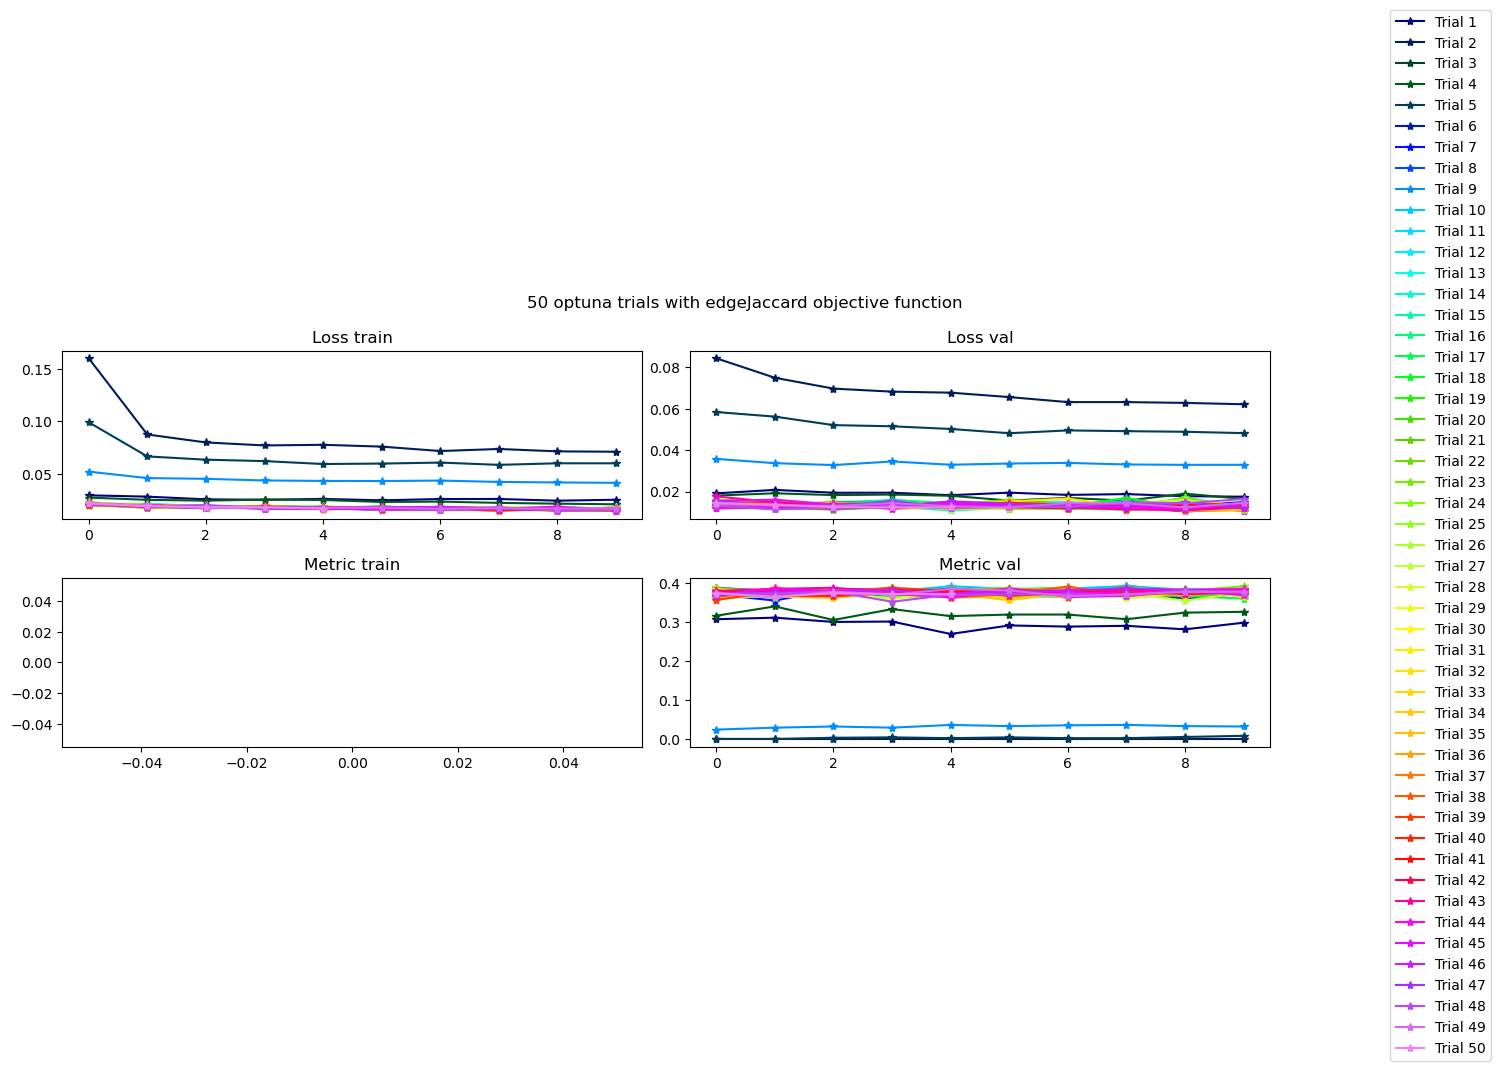

In [3]:
# trials, params, metric = read_optuna_log('/home/emidan19/Desktop/deep-tempest/drunet/baseline/optuna/edgeJaccard_25trials/optuna_hparams.log')
trials, params, metric = read_optuna_log('/home/emidan19/Desktop/deep-tempest/drunet/baseline/optuna/edgeJaccard_50trials1/optuna_hparams.log')
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 0.9,len(trials))]
# plt.figure()
# for i,trial in enumerate(trials):
#     plt.plot(trial['train_metric'],label = f'Trial {i+1}', color=colors[i])
# plt.legend()
# plt.grid()
# plt.show()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
plt.suptitle(f'{len(trials)} optuna trials with {metric} objective function')
for i,trial in enumerate(trials):
    ax[0,0].set_title('Loss train')
    ax[0,0].plot(trial['train_loss'],'-*', color=colors[i])
    ax[0,0].grid()

    ax[0,1].set_title('Loss val')
    ax[0,1].plot(trial['val_loss'],'-*', color=colors[i])
    ax[0,1].grid()          

    ax[1,0].set_title('Metric train')
    ax[1,0].plot(trial['train_metric'],'-*', color=colors[i])
    ax[1,0].grid()

    ax[1,1].set_title('Metric val')
    ax[1,1].plot(trial['val_metric'],'-*',label = f'Trial {i+1}', color=colors[i])
    ax[1,1].grid()

fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.85)
plt.show()

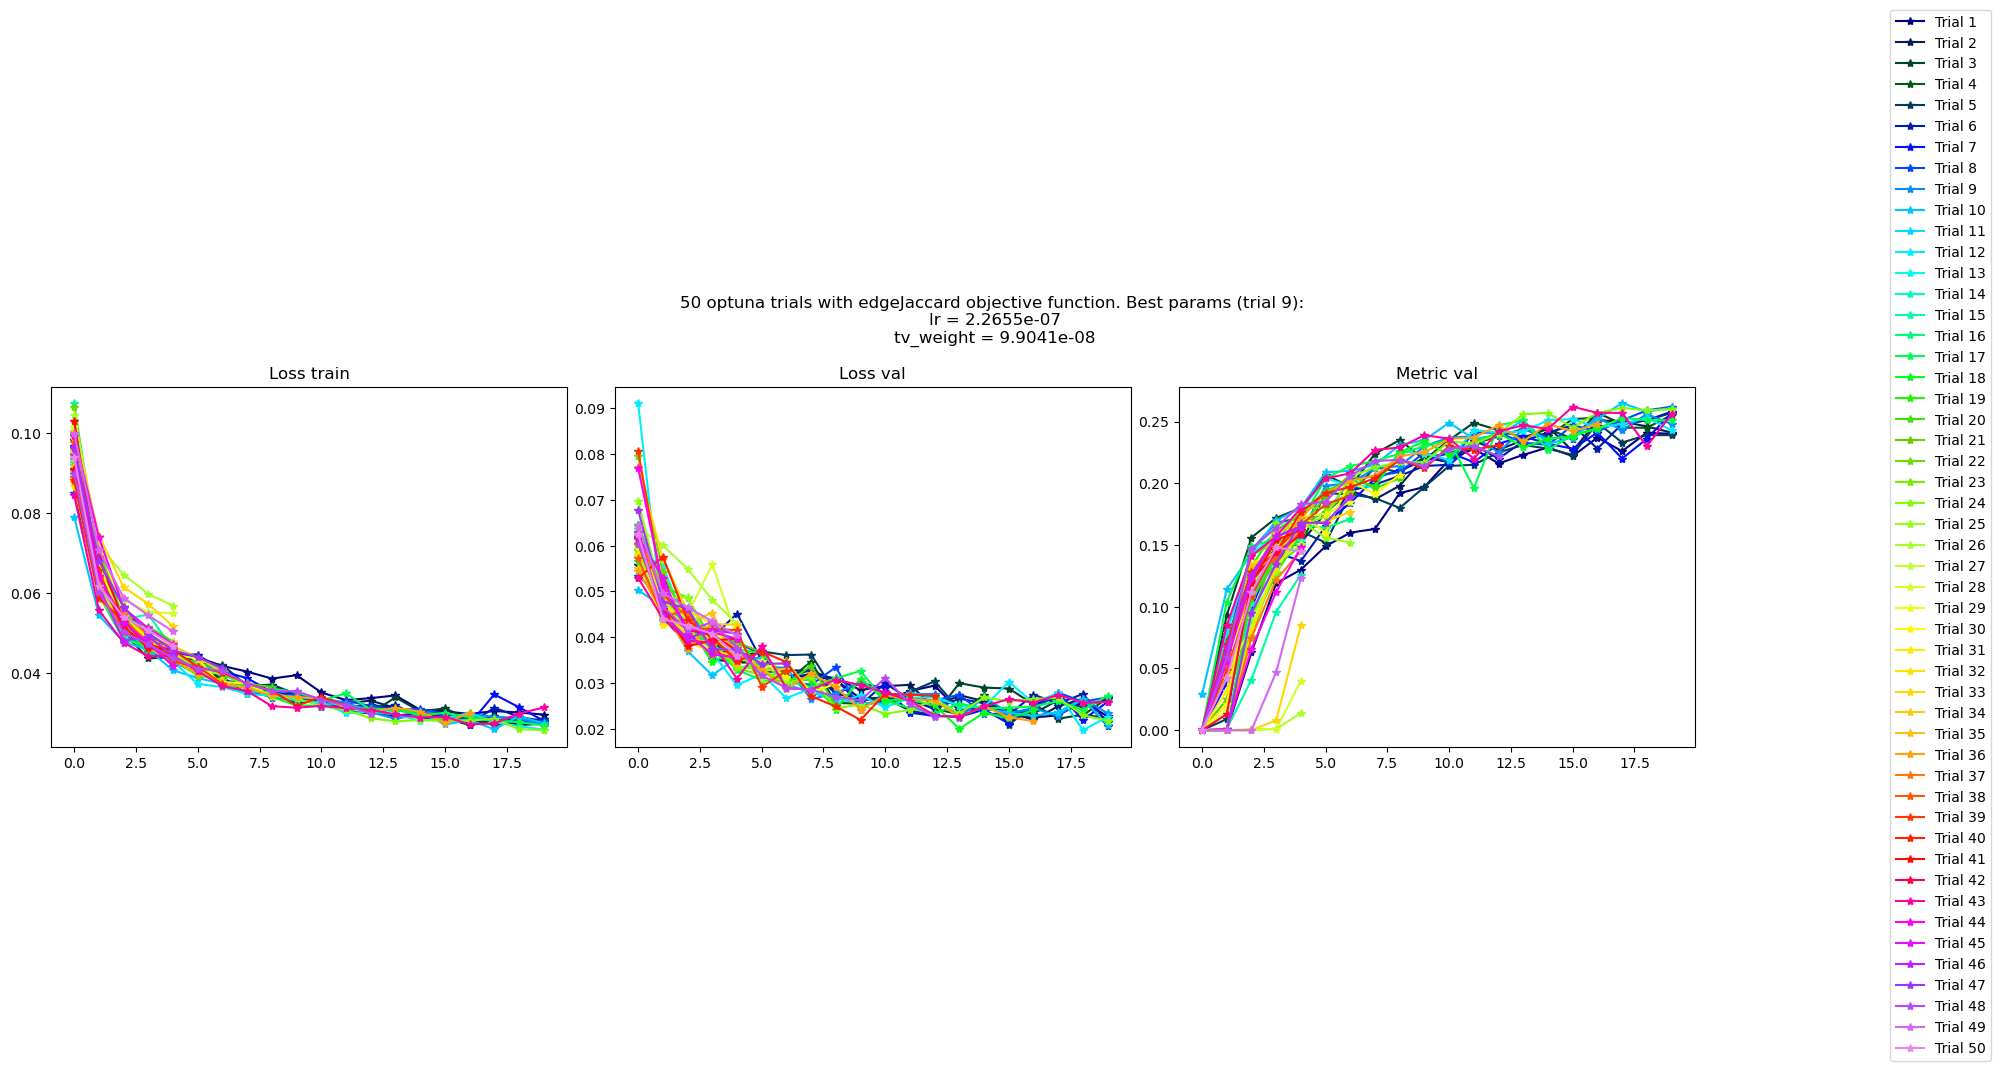

In [3]:
visualize_optuna_trials('/home/emidan19/Desktop/deep-tempest/drunet/baseline/optuna/drunet_gray_Jaccard_50trials/optuna_hparams.log')

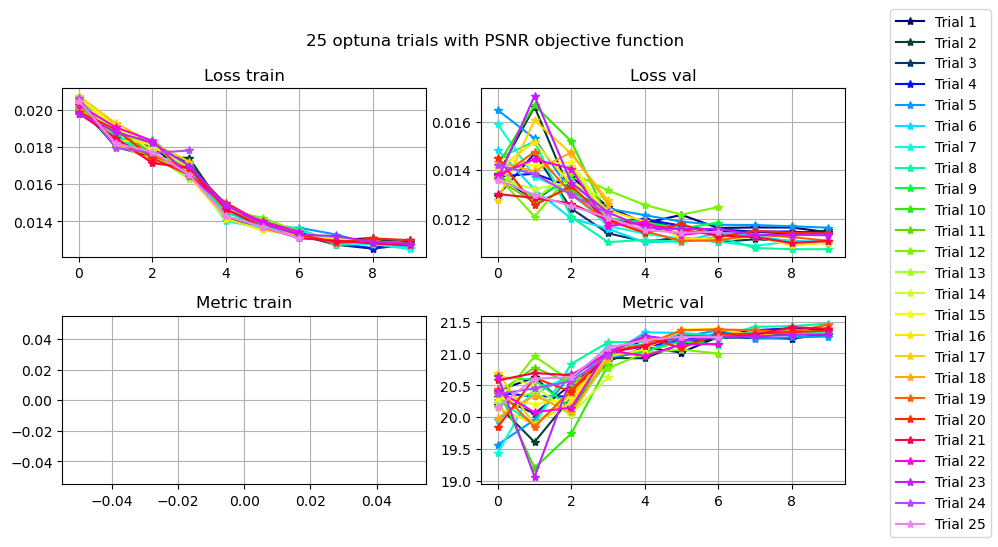

In [9]:
trials, params, metric = read_optuna_log('/home/emidan19/Desktop/deep-tempest/drunet/baseline/optuna/PSNR_25trials/optuna_hparams.log')
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 0.9,len(trials))]
# plt.figure()
# for i,trial in enumerate(trials):
#     plt.plot(trial['train_metric'],label = f'Trial {i+1}', color=colors[i])
# plt.legend()
# plt.grid()
# plt.show()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
plt.suptitle(f'{len(trials)} optuna trials with {metric} objective function')
for i,trial in enumerate(trials):
    ax[0,0].set_title('Loss train')
    ax[0,0].plot(trial['train_loss'],'-*', color=colors[i])
    ax[0,0].grid()

    ax[0,1].set_title('Loss val')
    ax[0,1].plot(trial['val_loss'],'-*', color=colors[i])
    ax[0,1].grid()          

    ax[1,0].set_title('Metric train')
    ax[1,0].plot(trial['train_metric'],'-*', color=colors[i])
    ax[1,0].grid()

    ax[1,1].set_title('Metric val')
    ax[1,1].plot(trial['val_metric'],'-*',label = f'Trial {i+1}', color=colors[i])
    ax[1,1].grid()

fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.85)
plt.show()